### Started Importing the Datasets

In [100]:
pip install dbfread

Note: you may need to restart the kernel to use updated packages.


In [101]:
#importing all packages for the project
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from dbfread import DBF
%matplotlib inline

In [102]:
#reading in the csv file
population = pd.read_csv('../data/estimated_pop_2018.csv')

In [103]:
#reading in the shp file
counties = gpd.read_file('../data/county/tncounty.shp')

In [104]:
#reading in the shp file
tornado_tracks = gpd.read_file('../data/tornado/HistTornadoTracks.shp')

In [105]:
#reading in the dbf file
traffic_dbf = DBF('../data/TrfcHistYR.dbf')

In [106]:
#iterating through the dbf file to make a dataframe
traffic_data = pd.DataFrame(iter(traffic_dbf))

### Started Slight Cleaning

In [107]:
#changing the espg to match with other espg
counties = counties.to_crs('EPSG:4326')

In [108]:
#changing the espg to match with other espg
tornado_tracks = tornado_tracks.to_crs('EPSG:4326')

In [109]:
#renaming the name column in the counties dataframe
counties.rename(columns={'NAME': 'COUNTY'}, inplace=True)

In [110]:
#dropping an unecessary column
counties = counties.drop(['OBJECTID'], axis = 1)

In [111]:
#removing rows where the lat and long were equal to zero
indexNames = traffic_data[(traffic_data['X'] == 0)].index
traffic_data.drop(indexNames, inplace=True)

In [112]:
#renaming columns for better readability
tornado_tracks.rename(columns={'len':'len(mi)', 'mag':'magnitude', 'wid':'wid(yrd)',
                              'inj':'injured', 'fat':'fatalities'}, inplace = True)

### Lets Start to Explore the Datasets

In [113]:
#checking the crs of the counties dataframe
counties.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [114]:
#reading the population info
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Counties        95 non-null     object
 1   Census          95 non-null     object
 2   Estimates Base  95 non-null     object
 3   2010            95 non-null     object
 4   2011            95 non-null     object
 5   2012            95 non-null     object
 6   2013            95 non-null     object
 7   2014            95 non-null     object
 8   2015            95 non-null     object
 9   2016            95 non-null     object
 10  2017            95 non-null     object
 11  2018            95 non-null     object
 12  2019            95 non-null     object
dtypes: object(13)
memory usage: 9.8+ KB


In [115]:
#reading the counties info
counties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   COUNTY      95 non-null     object  
 1   KEY         95 non-null     object  
 2   SHAPE_AREA  95 non-null     float64 
 3   SHAPE_LEN   95 non-null     float64 
 4   geometry    95 non-null     geometry
dtypes: float64(2), geometry(1), object(2)
memory usage: 3.8+ KB


In [116]:
#reading the tornado info
tornado_tracks.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1145 entries, 0 to 1144
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    1145 non-null   int64   
 1   om          1145 non-null   int64   
 2   yr          1145 non-null   int64   
 3   mo          1145 non-null   int64   
 4   dy          1145 non-null   int64   
 5   date        1145 non-null   object  
 6   time        1145 non-null   object  
 7   tz          1145 non-null   int64   
 8   st          1145 non-null   object  
 9   stf         1145 non-null   int64   
 10  stn         1145 non-null   int64   
 11  magnitude   1145 non-null   int64   
 12  injured     1145 non-null   int64   
 13  fatalities  1145 non-null   int64   
 14  loss        612 non-null    float64 
 15  closs       1145 non-null   float64 
 16  slat        1145 non-null   float64 
 17  slon        1145 non-null   float64 
 18  elat        1145 non-null   float64 
 19

In [117]:
#reading the traffic info
traffic_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 376787 entries, 0 to 376812
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   STATION_ID  376787 non-null  object 
 1   STN_NUMBER  376787 non-null  object 
 2   COUNTY      376787 non-null  object 
 3   LOCATION    376787 non-null  object 
 4   YEAR        376787 non-null  object 
 5   ADJAVGDLY   376787 non-null  float64
 6   RTE_NUMBER  376787 non-null  object 
 7   X           376787 non-null  float64
 8   Y           376787 non-null  float64
dtypes: float64(3), object(6)
memory usage: 28.7+ MB


### Creating a list of all counties

In [118]:
#listed all counties in Tennessee to iterate through
county_list = ['Anderson', 'Bedford', 'Benton', 'Bledsoe', 'Blount', 'Bradley', 'Campbell', 'Cannon', 'Carroll', 'Carter', 
               'Cheatham', 'Chester', 'Claiborne', 'Clay', 'Cocke', 'Coffee', 'Crockett', 'Cumberland', 'Davidson', 
               'Decatur', 'DeKalb', 'Dickson', 'Dyer', 'Fayette', 'Fentress', 'Franklin', 'Gibson', 'Giles', 'Grainger', 
               'Greene', 'Grundy', 'Hamblen', 'Hamilton', 'Hancock',
               'Hardeman', 'Hardin', 'Hawkins', 'Haywood', 'Henderson',
               'Henry', 'Hickman', 'Houston', 'Humphreys', 'Jackson', 'Jefferson', 'Johnson', 
               'Knox', 'Lake', 'Lauderdale', 
               'Lawrence', 'Lewis', 'Lincoln', 'Loudon', 'McMinn', 'McNairy', 'Macon', 
               'Madison', 'Marion', 'Marshall', 'Maury', 
               'Meigs', 'Monroe', 'Montgomery', 'Moore', 'Morgan', 
               'Obion', 'Overton', 'Perry', 'Pickett', 'Polk', 'Putnam', 'Rhea', 
               'Roane', 'Robertson', 'Rutherford', 'Scott', 
               'Sequatchie', 'Sevier', 'Shelby', 'Smith', 'Stewart', 'Sullivan', 'Sumner', 
               'Tipton', 'Trousdale', 'Unicoi', 'Union', 'Van Buren', 'Warren', 'Washington', 'Wayne', 
               'Weakley', 'White', 'Williamson', 'Wilson']

### Cleaning the Population Data

In [119]:
#creating a new column with the counties list to repace the other county column
population['county_list'] = county_list

In [120]:
#dropping unecessary columns
population = population.drop(['Estimates Base', 'Census', 'Counties', '2010', '2011', '2012', '2013', 
                              '2014', '2015', '2016', '2017', '2019'], axis = 1)

In [121]:
#renaming columns for consistency
population.rename(columns={'county_list': 'COUNTY', '2018': 'pop'}, inplace=True)

In [122]:
#removing commas to change the pop column to an integer
population['pop']=population['pop'].str.replace(',','')

In [123]:
#changing the datatype of the pop column to an integer
population['pop'] = population['pop'].astype('int64')

In [124]:
#checking to make sure it converted correctly
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pop     95 non-null     int64 
 1   COUNTY  95 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


### Creating a Traffic Subset That Only Includes The Year 2018

In [125]:
#subsetting the traffic data
traffic_data_2018 = traffic_data[traffic_data['YEAR'] == '2018']

### Cleaning the 2018 Traffic Data

In [126]:
#dropping unecessary columns
traffic_data_2018 = traffic_data_2018.drop(['STN_NUMBER', 'LOCATION', 'RTE_NUMBER'], axis = 1)

In [127]:
#renaming columns for consistency
traffic_data_2018 = traffic_data_2018.rename(columns = {'X':'LONG','Y':'LAT'})

In [128]:
#changing datatypes for the average daily traffic
traffic_data_2018['ADJAVGDLY'] = traffic_data_2018['ADJAVGDLY'].astype('int64')

In [129]:
#checking to make sure the column converted correctly
traffic_data_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12488 entries, 0 to 376779
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   STATION_ID  12488 non-null  object 
 1   COUNTY      12488 non-null  object 
 2   YEAR        12488 non-null  object 
 3   ADJAVGDLY   12488 non-null  int64  
 4   LONG        12488 non-null  float64
 5   LAT         12488 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 682.9+ KB


### Creating a GeoDataFrame for Traffic Data 2018

In [130]:
#converting the traffic data to a geodataframe
geo_traffic_data = gpd.GeoDataFrame(
    traffic_data_2018, crs = 'EPSG:4326', geometry=gpd.points_from_xy(traffic_data_2018.LONG, traffic_data_2018.LAT))

In [131]:
#checking the crs
geo_traffic_data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [132]:
#checking to make sure the dataframe converted correctly
geo_traffic_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 12488 entries, 0 to 376779
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATION_ID  12488 non-null  object  
 1   COUNTY      12488 non-null  object  
 2   YEAR        12488 non-null  object  
 3   ADJAVGDLY   12488 non-null  int64   
 4   LONG        12488 non-null  float64 
 5   LAT         12488 non-null  float64 
 6   geometry    12488 non-null  geometry
dtypes: float64(2), geometry(1), int64(1), object(3)
memory usage: 780.5+ KB


### Creating subset dataframe from traffic, county, and population data

In [133]:
#creating a groupby dataframe
geo_group = geo_traffic_data.groupby('COUNTY')['ADJAVGDLY'].mean().reset_index()

In [134]:
#rounding the decimals of the average daily traffic column
geo_group['ADJAVGDLY'] = geo_group['ADJAVGDLY'].round(decimals = 2)

In [135]:
#merging the groupby dataframe with the population dataframe
traffic_pop_geo = geo_group.merge(population, on='COUNTY')

In [136]:
#merging the traffic and pop dataframe with the counties dataframe
traffic_pop_geo = counties.merge(traffic_pop_geo, on = 'COUNTY')

In [137]:
#checking to make sure it converted correctly
traffic_pop_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 95 entries, 0 to 94
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   COUNTY      95 non-null     object  
 1   KEY         95 non-null     object  
 2   SHAPE_AREA  95 non-null     float64 
 3   SHAPE_LEN   95 non-null     float64 
 4   geometry    95 non-null     geometry
 5   ADJAVGDLY   95 non-null     float64 
 6   pop         95 non-null     int64   
dtypes: float64(3), geometry(1), int64(1), object(2)
memory usage: 5.9+ KB


In [138]:
#creating a new column that normalizes daily traffic by population
traffic_pop_geo['norm_avgdly'] = traffic_pop_geo['ADJAVGDLY']/traffic_pop_geo['pop']*5000
traffic_pop_geo['norm_avgdly'] = traffic_pop_geo['norm_avgdly'].round(decimals = 2)

### Cleaning the Tornado Data

## NOTE: ALL TIME ZONES HAVE BEEN CONVERTED TO CST FOR THIS DATASET

In [139]:
#dropping unecessary columns
tornado_tracks = tornado_tracks.drop(['stf','om', 'Pre_1996_L', 'tz', 'stn', 'fc'], axis = 1)

In [140]:
#removing lats that have zero in them
indexElat = tornado_tracks[(tornado_tracks['elat'] == 0)].index
tornado_tracks.drop(indexElat, inplace=True)

In [141]:
#removing longs that have zero in them
indexElon = tornado_tracks[(tornado_tracks['elon'] == 0)].index
tornado_tracks.drop(indexElon, inplace=True)

In [142]:
#converting the width into a new column, width in meters
tornado_tracks['wid(m)'] = tornado_tracks['wid(yrd)']*0.9144
tornado_tracks['wid(m)'] = tornado_tracks['wid(m)'].round(decimals = 2)

In [143]:
#changing the time column to be datetime
tornado_tracks['time'] = tornado_tracks.time.astype('datetime64[ns]')

In [144]:
#changing the time column to only show the time of day
tornado_tracks['time'] = tornado_tracks['time'].dt.time

In [145]:
#changing the date column to be datetime
tornado_tracks['date'] = tornado_tracks['date'].astype('datetime64[ns]')

In [146]:
#checking to make sure the changes happened correctly
tornado_tracks.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 817 entries, 7 to 1144
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   OBJECTID    817 non-null    int64         
 1   yr          817 non-null    int64         
 2   mo          817 non-null    int64         
 3   dy          817 non-null    int64         
 4   date        817 non-null    datetime64[ns]
 5   time        817 non-null    object        
 6   st          817 non-null    object        
 7   magnitude   817 non-null    int64         
 8   injured     817 non-null    int64         
 9   fatalities  817 non-null    int64         
 10  loss        606 non-null    float64       
 11  closs       817 non-null    float64       
 12  slat        817 non-null    float64       
 13  slon        817 non-null    float64       
 14  elat        817 non-null    float64       
 15  elon        817 non-null    float64       
 16  len(mi)     817 n

### Experimenting Plotting the Data

In [147]:
#gplt.pointplot(geo_traffic_data, projection=gcrs.AlbersEqualArea(), hue = 'ADJAVGDLY', legend=True, figsize = (20,20))

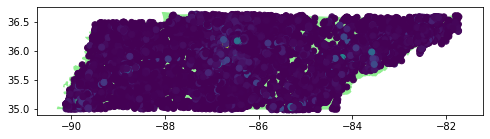

In [148]:
ax = counties.plot(figsize = (8, 10), color = 'lightgreen')
geo_traffic_data.plot( ax = ax, column = 'ADJAVGDLY');
plt.show();

<AxesSubplot:xlabel='LONG', ylabel='LAT'>

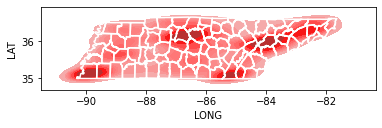

In [248]:
fig, ax = plt.subplots()
sns.kdeplot(x = 'LONG', y = 'LAT', ax = ax, fill = True, color = 'red', data = geo_traffic_data)
counties.boundary.plot(ax = ax, figsize = (8, 10), color = 'white', edgecolor = 'black')

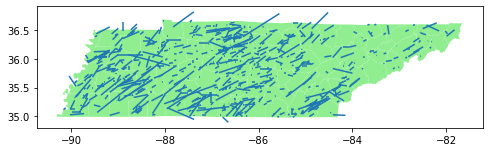

In [150]:
ax = counties.plot(figsize = (8, 10), color = 'lightgreen')
tornado_tracks.plot( ax = ax);
plt.show();

In [151]:
davidson = counties.loc[counties['COUNTY'] == 'Davidson']
davidson.shape

(1, 5)

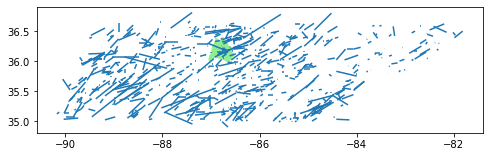

In [152]:
ax = davidson.plot(figsize = (8, 10), color = 'lightgreen')
tornado_tracks.plot( ax = ax);
plt.show();

### Coding Breakthrough Below

In [153]:
davidson_tornado = gpd.overlay(tornado_tracks, davidson, how = 'intersection')

<AxesSubplot:>

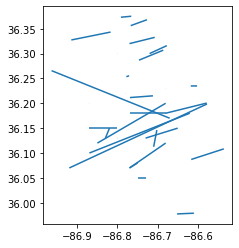

In [154]:
davidson_tornado.plot()

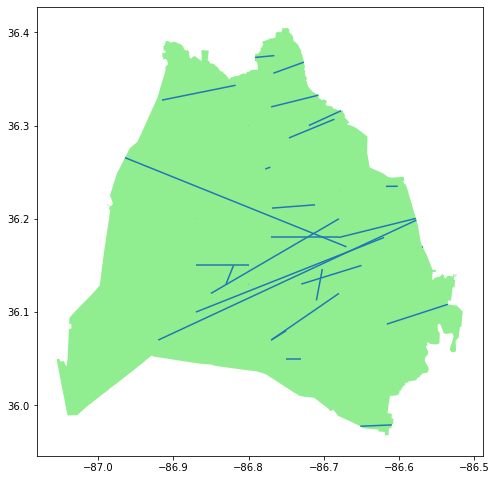

In [155]:
ax = davidson.plot(figsize = (8, 10), color = 'lightgreen')
davidson_tornado.plot(ax = ax);
plt.show();

### Creating the final geodataframe for the project.

In [156]:
county_tornado = gpd.overlay(tornado_tracks, traffic_pop_geo, how = 'intersection')

In [157]:
county_tornado.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1039 entries, 0 to 1038
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   OBJECTID     1039 non-null   int64         
 1   yr           1039 non-null   int64         
 2   mo           1039 non-null   int64         
 3   dy           1039 non-null   int64         
 4   date         1039 non-null   datetime64[ns]
 5   time         1039 non-null   object        
 6   st           1039 non-null   object        
 7   magnitude    1039 non-null   int64         
 8   injured      1039 non-null   int64         
 9   fatalities   1039 non-null   int64         
 10  loss         732 non-null    float64       
 11  closs        1039 non-null   float64       
 12  slat         1039 non-null   float64       
 13  slon         1039 non-null   float64       
 14  elat         1039 non-null   float64       
 15  elon         1039 non-null   float64       
 16

### Cleaning the Dataset

In [158]:
#dropping unecessary columns
county_tornado = county_tornado.drop(['st'], axis = 1)

In [159]:
county_tornado.head()

,OBJECTID,yr,mo,dy,date,time,magnitude,injured,fatalities,loss,...,SHAPE_Leng,wid(m),COUNTY,KEY,SHAPE_AREA,SHAPE_LEN,ADJAVGDLY,pop,norm_avgdly,geometry
0,486,1952,2,13,1952-02-13,22:00:00,3,2,0,NaN,...,14471.538000,320.04,Lincoln,47103,1.591347e+10,612031.885628,3055.48,34189,446.85,"LINESTRING (-86.60000 35.22001, -86.47000 35.2..."
1,12375,1971,3,6,1971-03-06,14:39:00,1,0,0,NaN,...,78504.072723,182.88,Lincoln,47103,1.591347e+10,612031.885628,3055.48,34189,446.85,"LINESTRING (-86.83162 35.14984, -86.63000 35.1..."
2,14256,1973,5,19,1973-05-19,14:15:00,1,0,0,NaN,...,6906.317100,9.14,Lincoln,47103,1.591347e+10,612031.885628,3055.48,34189,446.85,"LINESTRING (-86.52000 35.25001, -86.47000 35.2..."
3,15187,1974,4,3,1974-04-03,18:45:00,4,121,11,NaN,...,63910.039346,731.52,Lincoln,47103,1.591347e+10,612031.885628,3055.48,34189,446.85,"LINESTRING (-86.50000 35.00001, -86.33505 35.1..."
4,18107,1977,6,6,1977-06-06,15:20:00,0,0,0,NaN,...,18032.989275,402.34,Lincoln,47103,1.591347e+10,612031.885628,3055.48,34189,446.85,"LINESTRING (-86.62000 35.20001, -86.47000 35.1..."


In [160]:
#there is overlap with tornadoes that go through multiple counties
county_tornado['OBJECTID'].value_counts()

26829    6
60069    4
56353    4
50519    4
38078    4
        ..
58203    1
58083    1
2913     1
39781    1
55295    1
Name: OBJECTID, Length: 816, dtype: int64

### Kanban Board Tasks

### 1. KPI: there are 816 tornadoes that struck Tennessee from the years 1950-2015

In [161]:
#ther will be some overlap with values repeating since I broke the dataset up by each county
county_tornado['OBJECTID'].nunique()

816

### 2. what counties have the most tornadoes?

In [162]:
#use county_tornado dataset

In [250]:
county_tornado['COUNTY'].value_counts()

Rutherford    31
Davidson      31
Sumner        29
Wilson        25
Lawrence      25
              ..
Unicoi         2
Johnson        2
Hancock        2
Hamblen        1
Clay           1
Name: COUNTY, Length: 95, dtype: int64

### Rutherford and Davidson have the most with 31, while Sumner has 29.

### 3. what counties have the most traffic?

In [163]:
#use traffic_pop_geo dataset

Text(0.5, 1.0, 'Top 5 Counties For Traffic')

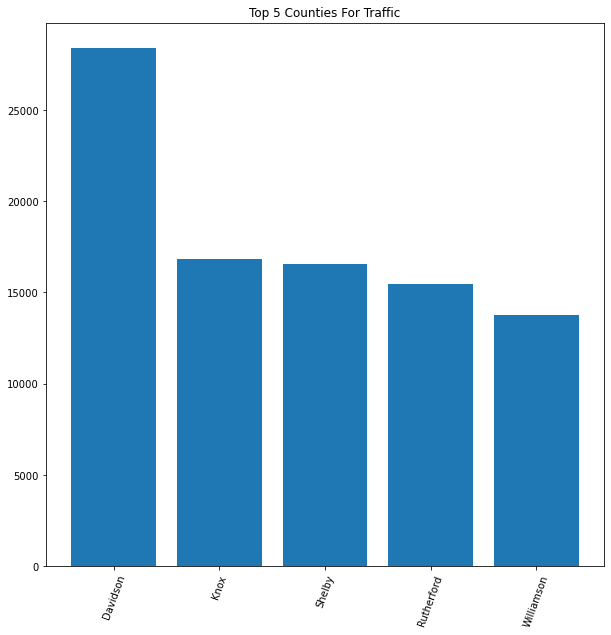

In [249]:
data = traffic_pop_geo.sort_values('ADJAVGDLY', ascending = False).head()
plt.figure(figsize = (10,10))
plt.bar('COUNTY', 'ADJAVGDLY', data = data)
plt.xticks(rotation = 70)
plt.title('Top 5 Counties For Traffic')

In [240]:
plt.xscale?

### 4. what year had the most tornadoes?

In [176]:
tornado_tracks['yr'].value_counts()

2011    97
2009    46
2003    45
2013    41
2008    36
1997    36
1974    34
1998    32
2002    30
2010    30
2012    28
2000    27
2006    25
1999    23
2005    23
1996    17
2015    16
1995    15
2004    15
2014    15
2001    14
1963    11
1994    11
2007    10
1971     9
1988     9
1952     8
1980     7
1957     7
1955     7
1977     7
1975     6
1993     6
1984     5
1985     5
1989     5
1953     5
1970     5
1991     4
1967     4
1964     4
1976     4
1956     4
1965     4
1961     3
1973     3
1972     3
1978     2
1959     2
1992     2
1982     2
1983     2
1968     1
1962     1
1979     1
1960     1
1986     1
1954     1
Name: yr, dtype: int64

### 2011 had 97 tornadoes, with 2009 having 46, and 2003 having 45

### 5. What time do tornadoes typically strike?

In [165]:
print(tornado_tracks['time'].describe())

count          817
unique         457
top       16:30:00
freq            12
Name: time, dtype: object


In [168]:
#print(tornado_tracks['time'].mean())

### They typically srike at 2:30 P.M.

### Plotting the Charts for Daily Traffic and Population

In [ ]:
fig, ax = plt.subplots(figsize=(16,4))
traffic_pop_geo.plot(column = 'norm_avgdly', 
              cmap = 'GnBu', 
              edgecolor = 'black', 
              legend = True,
              ax = ax)
plt.title('Average Daily Traffic Per Capita', fontsize = 14)
ax.axis('off');

In [ ]:
fig, ax = plt.subplots(figsize=(16,4))
traffic_pop_geo.plot(column = 'ADJAVGDLY', 
              cmap = 'GnBu', 
              edgecolor = 'black', 
              legend = True,
              ax = ax)
plt.title('Average Daily Traffic by County', fontsize = 14)
ax.axis('off');

In [ ]:
fig, ax = plt.subplots(figsize=(16,4))
traffic_pop_geo.plot(column = 'pop', 
              cmap = 'GnBu', 
              edgecolor = 'black', 
              legend = True,
              ax = ax)
plt.title('Population by County', fontsize = 14)
ax.axis('off');

### Exporting Necessary Tables to CSV For Dashboarding

In [169]:
county_tornado.to_csv(r'C:\Users\touch\Documents\nss\data\Tennessee_Tornadoes.csv', index = False)

In [170]:
counties.to_csv(r'C:\Users\touch\Documents\nss\data\Counties.csv', index = False)